In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

from scipy.stats import wasserstein_distance
from scipy.stats import binom
from scipy.stats import poisson
from scipy.stats import bernoulli
from scipy.stats import nbinom

### Auxiliry constants

In [2]:
uniform_const = "Uniform"
soliton_const = "Soliton"
geometric_const = "Geometric"
binomial_const = "Binomial"
poisson_one_const = "Poisson(1)"
poisson_onehalf_const = "Poisson(1/2)"
arbitrary_const = "Arbitrary"

poisson_with_hole_const = "Poisson with a hole in the support"
binomial_with_hole_const = "Binomial with a hole in the support"
uniform_with_hole_const = "Uniform with a hole in the support"
geometric_with_hole_const = "Geometric with a hole in the support"

### Auxiliry functions

In [3]:
def display_wasserstein_distance_info(w_range, n_range, text="", text2="Poisson"):

    print(f"W_1({text},{text2}) is monotonically decreasing: {is_monot_decreasing(w_range)}")
    print(f"W_1({text},{text2}) is monotonically increasing: {is_monot_increasing(w_range)}")
    print()
    
    plt.figure(figsize=(10,5))
    
    plt.plot(n_range, w_range, c="black")
    
    plt.title(f"W_1({text},{text2})") 
    plt.xlabel("n")
    plt.ylabel("W_1")
    
    plt.show()
    
def plot_pmf(x, y, title=""):
    plt.plot(x, y, 'ro')
    
    plt.title(title)
    plt.xlabel("k")
    plt.ylabel("PMF(k)")
    
    plt.show()
    
def get_relative_entropy(p1, p2=[]):
    if np.size(p2) == 0:
        return scipy.stats.entropy(p1)
    
    return scipy.stats.entropy(p1, p2)

def is_monot_increasing(arr):
    return all(float(fst) <= float(snd) for fst, snd in zip(arr, arr[1:]))

def is_monot_decreasing(arr):
    return all(float(fst) >= float(snd) for fst, snd in zip(arr, arr[1:]))

## Math functions

### PMF

In [4]:
def bin_pmf(n, m, p, k_star=-1):
    if k_star == -1:
        binom.pmf(m,n,p)
        
    if m == k_star:
        return 0
    elif m == k_star + 1:
        return binom.pmf(m,n,p) + binom.pmf(k_star,n,p)
    else:
        return binom.pmf(m,n,p)

def uniform_pmf(n,k,k_star=1):
    if k > n or k < 0:
        return 0
    
    if k_star == -1:
        return 1/(n+1)
    
    if k == k_star:
        return 0
    elif k == k_star-1:
        return 2/(n+1)
    else:
        return 1/(n+1)
    
def geom_pmf(k, k_star=-1,p=0.5):
    if k < 0: #or k > l:
        return 0
    
    if k_star == -1:
        return (1-p)**k * p

    if k == k_star:
        return 0
    elif k == k_star+1:
        return (1-p)**k * p + (1-p)**k_star * p 
    else:
        return (1-p)**k * p

def custom_dist_pmf(k,dist):
    if k >= np.size(dist) or k < 0:
        return 0

    return dist[0,k]



def benford_pmf(d):
    return np.log10(1+1/d)
    
def soliton_pmf(n, k):
    if k == 0:
        return 0
    
    if k == 1:
        return 1/n
    else:
        return 1/(k*(k-1))

### PMF of sum of RVs

In [5]:
def pmf_of_sum_bin(n, l, k, k_star, p=0.5):
    #return binom_func(l*n,k,p)

    if n == 1:
        return bin_pmf(l,k,p,k_star)
    
    return sum(pmf_of_sum_bin(n-1,l,i,k_star,p)*bin_pmf(l,k-i,p,k_star) for i in range(0, k+1))

def pmf_of_sum_geom(n, l, k, k_star, p=0.5):
    if n == 1:
        return geom_pmf(k,k_star,p)
    
    return sum(pmf_of_sum_geom(n-1,l,i,k_star,p)*geom_pmf(k-i,k_star,p) for i in range(0, k+1))

def pmf_of_sum_uniform(n, l, k, k_star):
    if n == 1:
        return uniform_pmf(l,k,k_star)
    
    return sum(pmf_of_sum_uniform(n-1,l,i,k_star)*uniform_pmf(l,k-i,k_star) for i in range(0, k+1))

def pmf_of_sum_custom(n, l, k, dist):
    if n == 1:
        return custom_dist_pmf(k,dist)
    
    return sum(pmf_of_sum_custom(n-1,l,i,dist)*custom_dist_pmf(k-i,dist) for i in range(0, k+1))

### PMF of thinning of RVs

In [6]:
def thinning_pmf_bin(n, k, l,k_star,p):
    return sum(pmf_of_sum_bin(n,l,j,k_star,p) * binom.pmf(k,j,1/n) for j in range(k, l*n+1))

def thinning_pmf_geom(n, k, l,k_star,p):
    return sum(pmf_of_sum_geom(n,l,j,k_star,p) * binom.pmf(k,j,1/n) for j in range(k, l*n+1))

def thinning_pmf_uniform(n, k, l,k_star):
    return sum(pmf_of_sum_uniform(n,l,j,k_star) * binom.pmf(k,j,1/n) for j in range(k, l*n+1))

def thinning_pmf_custom(n, k, l,dist):
    return sum(pmf_of_sum_custom(n,l,j,dist) * binom.pmf(k,j,1/n) for j in range(k, l*n+1))

### Functions for computing PMF on a given support

In [7]:
def get_poisson_pmf_array(K, poisson_param):
    poisson_arr = []
    
    for k in range(0,K+1):
        poisson_pmf_k = poisson.pmf(k,poisson_param)
        poisson_arr.append(poisson_pmf_k)
        
    return poisson_arr

def get_thinning_pmf_array_bin(K,n,l,k_star=-1,p=0.5):
    thinning_arr = []
    
    for k in range(0,n*K+1):
        thinning_pmf_k = thinning_pmf_bin(n,k,l,k_star,p)
        thinning_arr.append(thinning_pmf_k)
        
    return thinning_arr
   
def get_thinning_pmf_array_geom(K,n,l,k_star=0,p=0.5):
    thinning_arr = []
    
    for k in range(0,n*K+1):
        thinning_pmf_k = thinning_pmf_geom(n,k,l,k_star,p)
        thinning_arr.append(thinning_pmf_k)
        
    return thinning_arr

def get_thinning_pmf_array_uniform(K,n,l,k_star=-1):
    thinning_arr = []
    
    for k in range(0,n*K+1):
        thinning_pmf_k = thinning_pmf_uniform(n,k,l,k_star)
        thinning_arr.append(thinning_pmf_k)
        
    return thinning_arr
   
def get_thinning_pmf_array_custom(K,n,l,dist):
    thinning_arr = []
    
    for k in range(0,n*K+1):
        thinning_pmf_k = thinning_pmf_custom(n,k,l,dist)
        thinning_arr.append(thinning_pmf_k)
        
    return thinning_arr

# Examples

## Thinnings of arbitrary distributions

In [8]:
K = 5

dist1 = np.random.dirichlet(np.ones(K+1),size=1)
dist2 = np.random.dirichlet(np.ones(K+1),size=1)

exp1 = 0
exp2 = 0

for x in range(0,np.size(dist1)):
    exp1 += x*dist1[0,x]
    
for x in range(0,np.size(dist2)):
    exp2 += x*dist2[0,x]
    
print(f"dist1={dist1}")
print(f"dist2={dist2}")
print()
print(f"E[dist1]={exp1}")
print(f"E[dist2]={exp2}")

dist1=[[0.15041567 0.13201541 0.50325834 0.08505274 0.11840625 0.01085159]]
dist2=[[0.08536909 0.13794487 0.20482581 0.03977613 0.35567213 0.17641197]]

E[dist1]=1.9215732496307634
E[dist2]=2.9716732597720057


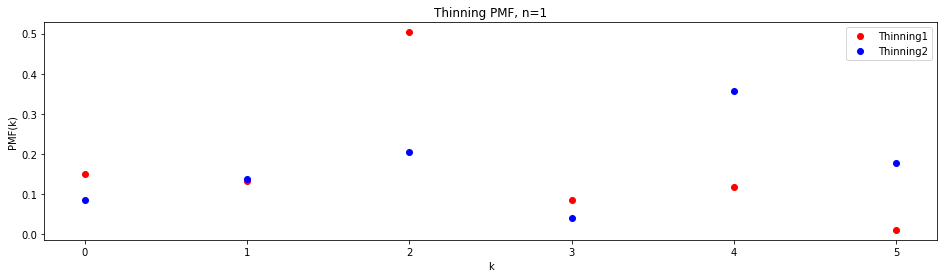

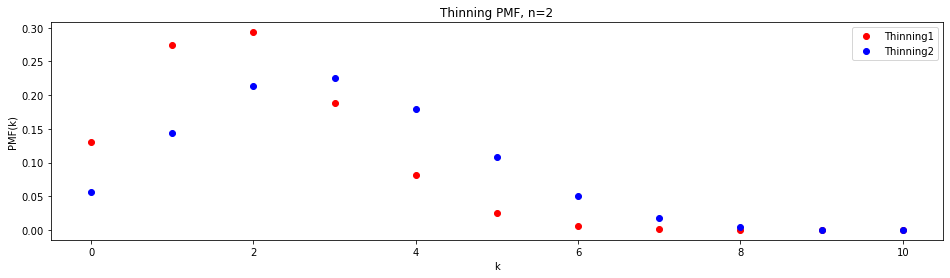

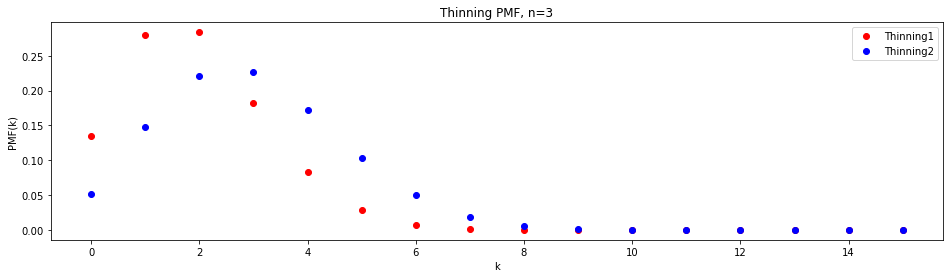

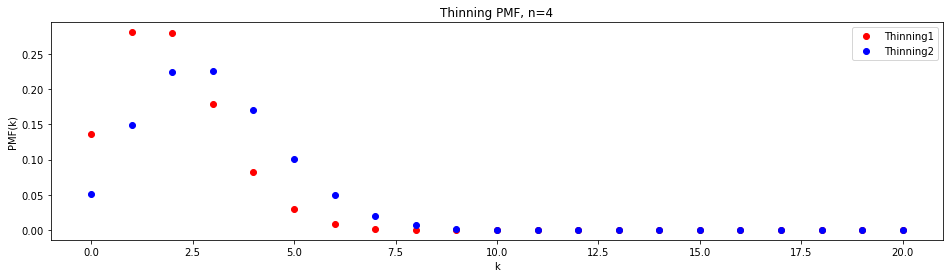

H(Arbitrary|Poisson(1.9215732496307634)) is monotonically decreasing: True (should always be true)
[0.6264751640545217, 0.31031552922883315, 0.28117855879037457, 0.2701408222468382]

H(Arbitrary) is monotonically increasing: True (should be true in ULC case)
H(Arbitrary) is monotonically decreasing: False (should be true in ULConvex case)
[1.6100950949302748, 1.9062086102750886, 1.912514541540916, 1.9154116691992389]

H(Arbitrary)_4=1.9154116691992389, H(Poisson(1.9215732496307634))=1.6571283972061177
H(Arbitrary|Poisson(1.9215732496307634))=0.2701408222468382

W_1= [1.0501000101412419, 1.0501000101412423, 1.050100010141241, 1.0501000101412419]

W_1(Thinning1,Thinning2) is monotonically decreasing: False
W_1(Thinning1,Thinning2) is monotonically increasing: False



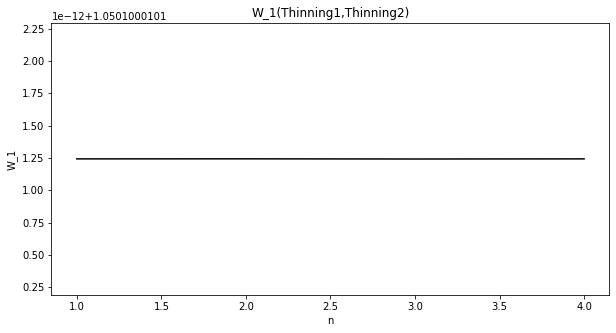

In [13]:
l = K
K_range = range(0,K+1)

n_max = 4
n_step = 1
n_range = range(1,n_max+1,n_step)

w_range = []

entropy = []
rel_entropy = []

k_star = 3

for n in n_range:
    K_range = range(0,n*K+1)

    p1 = get_thinning_pmf_array_custom(K, n, l, dist1)
    p2 = get_thinning_pmf_array_custom(K, n, l, dist2)

    #print(f"n={n}, pmf1 sum={sum(p1)}")
    #print(f"n={n}, pmf2 sum={sum(p2)}")

    plt.figure(figsize=(16,4))

    plt.title(f"Thinning PMF, n={n}")
    plt.xlabel("k")
    plt.ylabel("PMF(k)")
    
    plt.plot(K_range, p1, 'ro', label=f'Thinning1')
    plt.plot(K_range, p2, 'bo', label=f'Thinning2')
    
    plt.legend()
    plt.show()

    w = wasserstein_distance(K_range, K_range, p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

thinning_rv = arbitrary_const

print(f"H({thinning_rv}|Poisson({exp1})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({exp1}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({exp1}))={rel_entropy[-1]}")
    
print()
print("W_1=",w_range)
print()

display_wasserstein_distance_info(w_range, n_range, f"Thinning1", "Thinning2")

## Thinning of arbitrary distribution & Poisson distribution

dist=[[0.18087552 0.0518739  0.08490727 0.23124882 0.25208566 0.13587461
  0.06313421]]


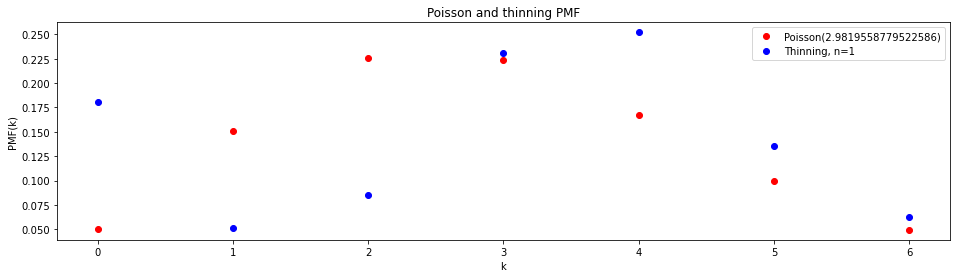

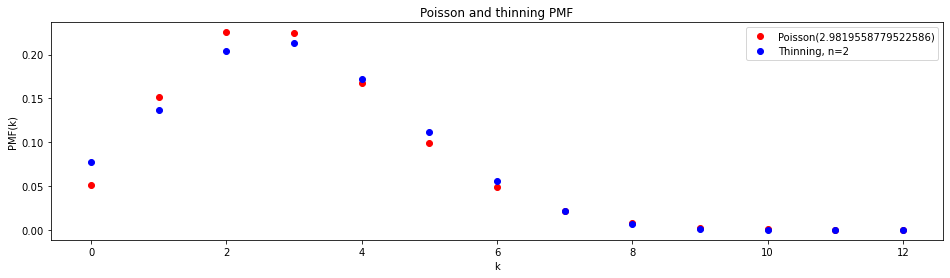

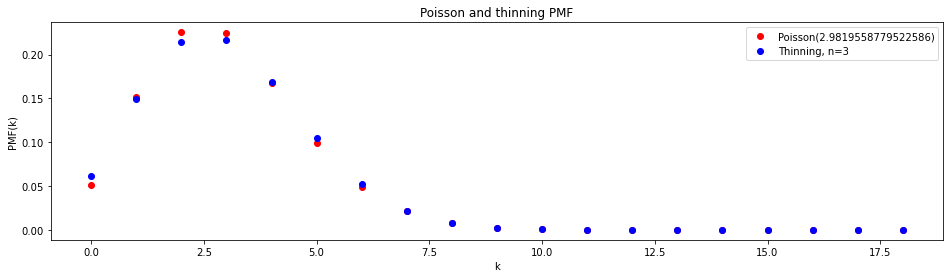

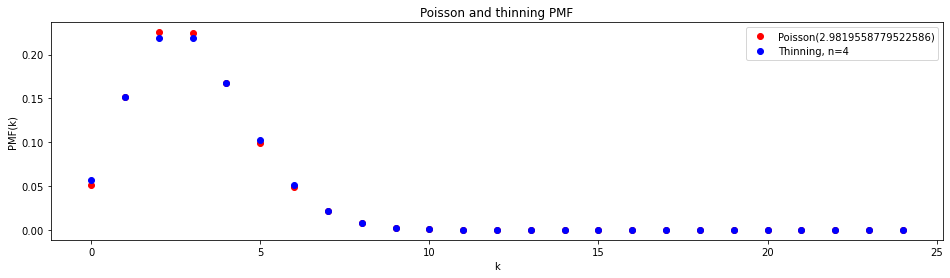

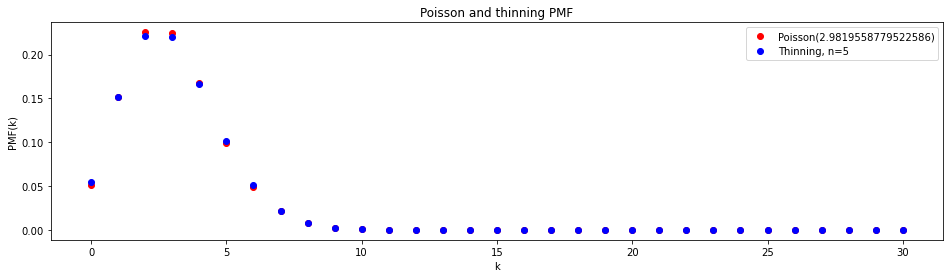

H(Arbitrary|Poisson(2.9819558779522586)) is monotonically decreasing: True (should always be true)
[0.2272204679654133, 0.010166102750320297, 0.0018821893510383317, 0.0006375412408523479, 0.00029297153554485564]

H(Arbitrary) is monotonically increasing: False (should be true in ULC case)
H(Arbitrary) is monotonically decreasing: False (should be true in ULConvex case)
[1.8037729178732609, 1.9582451510123506, 1.9480354463275356, 1.9421185756577688, 1.9387629741781967]

H(Arbitrary)_5=1.9387629741781967, H(Poisson(2.9819558779522586))=1.9281674136190465
H(Arbitrary|Poisson(2.9819558779522586))=0.00029297153554485564

[0.4577082800192891, 0.09614904745645517, 0.04473320026022328, 0.02710851022974794, 0.01957316867551645]

W_1(Thinning,Poisson(2.9819558779522586)) is monotonically decreasing: True
W_1(Thinning,Poisson(2.9819558779522586)) is monotonically increasing: False



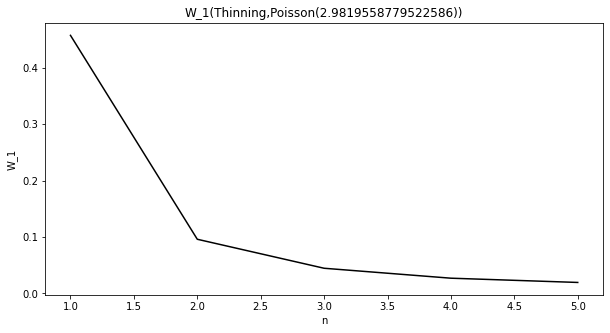

In [14]:
K = 6
l = K
K_range = range(0,K+1)

dist = np.random.dirichlet(np.ones(K+1),size=1)
print(f"dist={dist}")

lmb = 0
for x in range(0,np.size(dist)):
    lmb += x*dist[0,x]
    
p1 = get_poisson_pmf_array(K, lmb)
#print("p1", sum(p1))

n_max = 5
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

k_star = 1
p = 0.5

for n in n_range:
    K_range = range(0,n*K+1)
    
    p1 = get_poisson_pmf_array(K*n, lmb)
    p2 = get_thinning_pmf_array_custom(K, n, l, dist)
    
    #print(f"n={n}, pmf sum={sum(p1)}")
    #print(f"n={n}, pmf sum={sum(p2)}")
    
    plt.figure(figsize=(16,4))
    
    plt.title("Poisson and thinning PMF")
    plt.xlabel("k")
    plt.ylabel("PMF(k)")
    
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    
    plt.legend()
    plt.show()
    
    w = wasserstein_distance(K_range, K_range, p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

thinning_rv = arbitrary_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()

display_wasserstein_distance_info(w_range, n_range, f"Thinning", f"Poisson({lmb})")

## Thinning of geometric distribution with a hole in the support & Poisson distribution

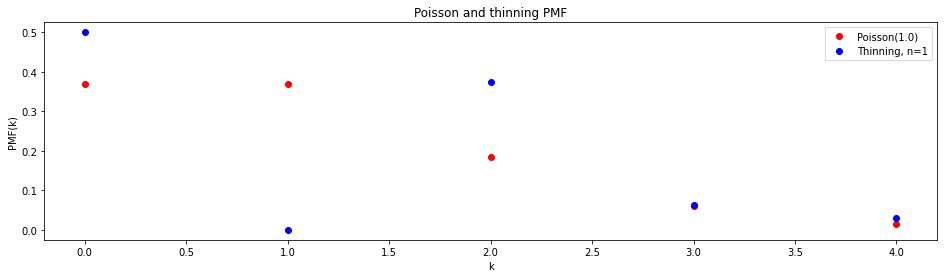

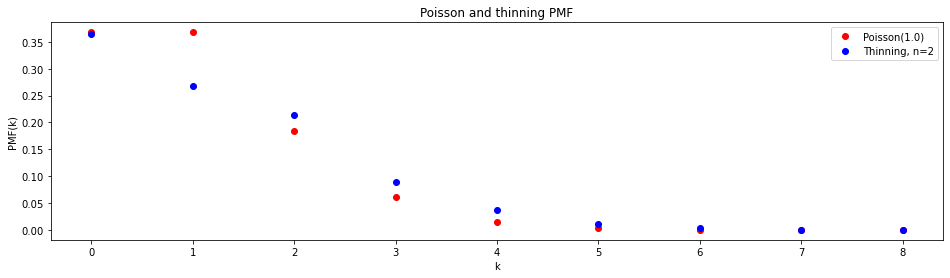

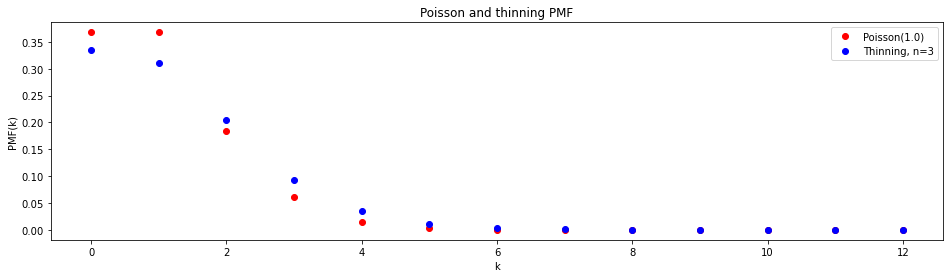

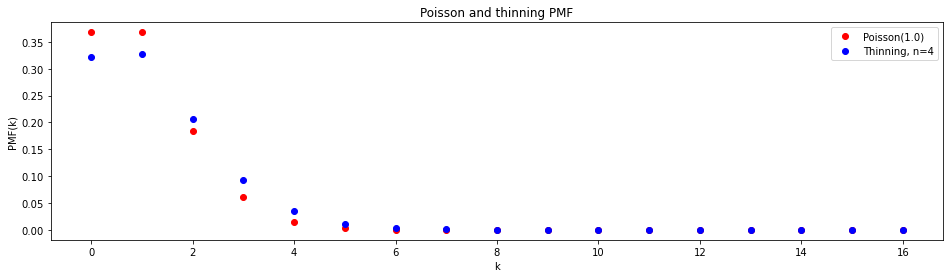

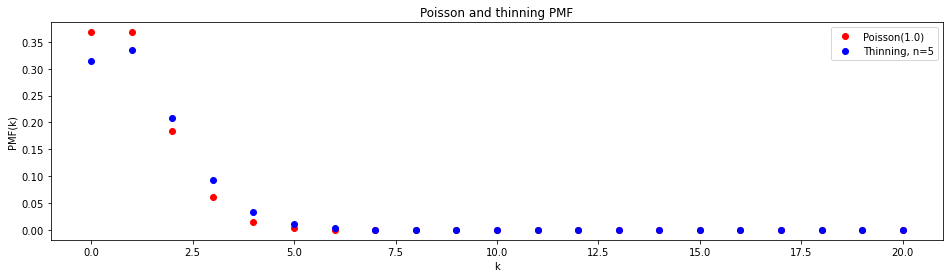

H(Geometric with a hole in the support|Poisson(1.0)) is monotonically decreasing: True (should always be true)
[0.4864085786088612, 0.042949577430001266, 0.03609312425298271, 0.03443474413923641, 0.03316596379664284]

H(Geometric with a hole in the support) is monotonically increasing: False (should be true in ULC case)
H(Geometric with a hole in the support) is monotonically decreasing: False (should be true in ULConvex case)
[0.9963551491815207, 1.46348304084363, 1.4743512973443464, 1.4718212037915488, 1.467473886351558]

H(Geometric with a hole in the support)_5=1.467473886351558, H(Poisson(1.0))=1.3048422422562516
H(Geometric with a hole in the support|Poisson(1.0))=0.03316596379664284

[0.40595533498759306, 0.20443085542465983, 0.23282630106241903, 0.24371225273482822, 0.24763199388865897]

W_1(Thinning,Poisson(1.0)) is monotonically decreasing: False
W_1(Thinning,Poisson(1.0)) is monotonically increasing: False



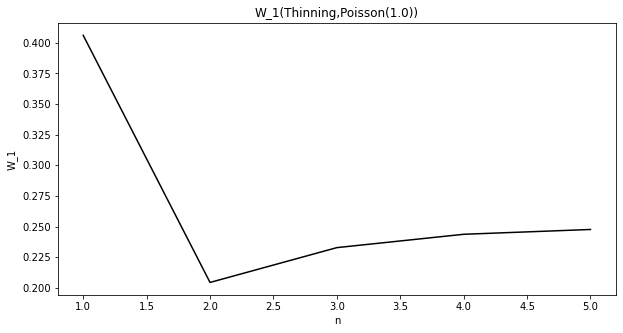

In [15]:
K = 4
l = K

n_max = 5
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

k_star = 1
p = 0.5
lmb = (1-p)/p

for n in n_range:
    K_range = range(0,n*K+1)
    
    p1 = get_poisson_pmf_array(K*n, lmb)
    p2 = get_thinning_pmf_array_geom(K, n, l, k_star, p)
    
    #print(f"n={n}, pmf sum={sum(p1)}")
    #print(f"n={n}, pmf sum={sum(p2)}")
    
    plt.figure(figsize=(16,4))
    
    plt.title("Poisson and thinning PMF")
    plt.xlabel("k")
    plt.ylabel("PMF(k)")
    
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    
    plt.legend()
    plt.show()
    
    w = wasserstein_distance(K_range, K_range, p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

thinning_rv = geometric_with_hole_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()

display_wasserstein_distance_info(w_range, n_range, f"Thinning", f"Poisson({lmb})")

## Thinning of binomial distribution with a hole in the support & Poisson distribution

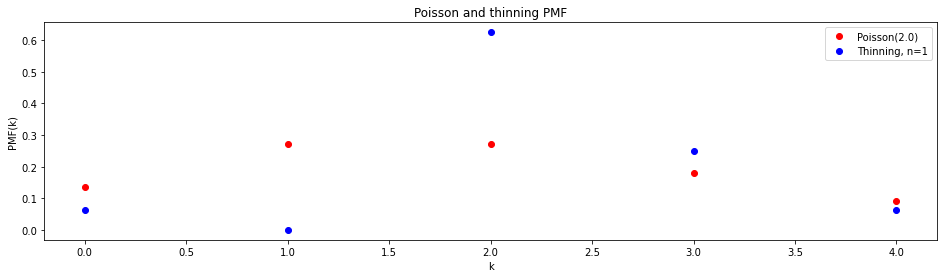

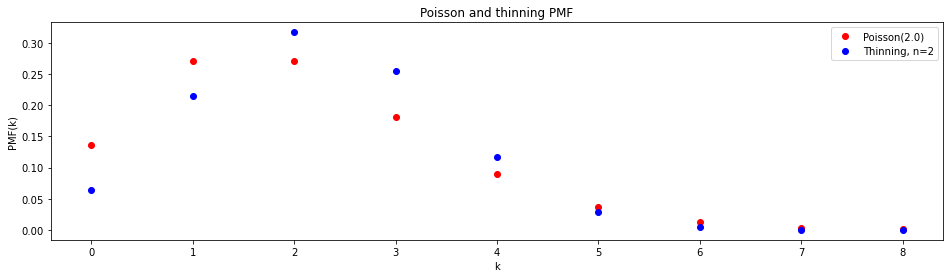

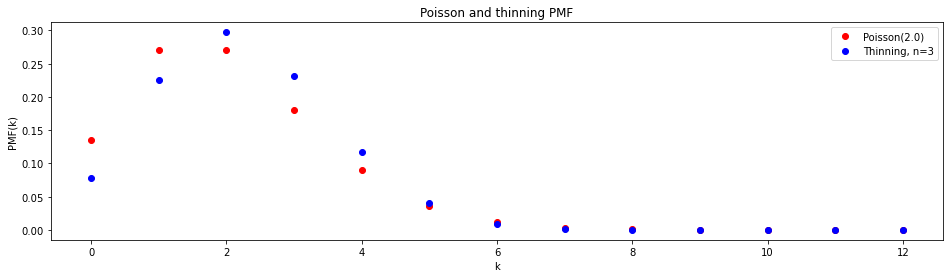

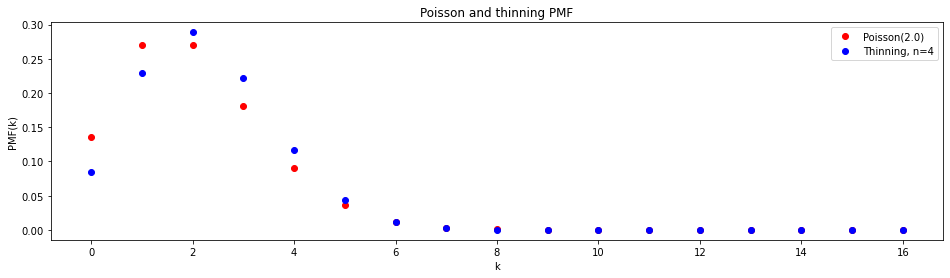

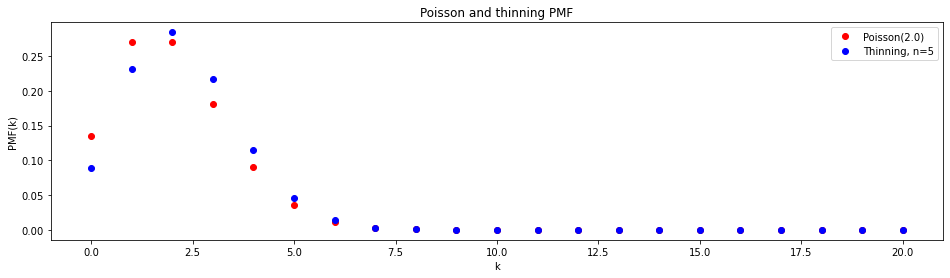

H(Binomial with a hole in the support|Poisson(2.0)) is monotonically decreasing: True (should always be true)
[0.47921476351063247, 0.057114194962329515, 0.031558743862248724, 0.023798136619490207, 0.020453196830559288]

H(Binomial with a hole in the support) is monotonically increasing: True (should be true in ULC case)
H(Binomial with a hole in the support) is monotonically decreasing: False (should be true in ULConvex case)
[0.9868994488385301, 1.5986278187451237, 1.668990768823453, 1.6986724585341002, 1.7150454902010919]

H(Binomial with a hole in the support)_5=1.7150454902010919, H(Poisson(2.0))=1.7048826439327862
H(Binomial with a hole in the support|Poisson(2.0))=0.020453196830559288

[0.5059523809523812, 0.3220341268095994, 0.2716829285769136, 0.25765512146387237, 0.25238971097814067]

W_1(Thinning,Poisson(2.0)) is monotonically decreasing: True
W_1(Thinning,Poisson(2.0)) is monotonically increasing: False



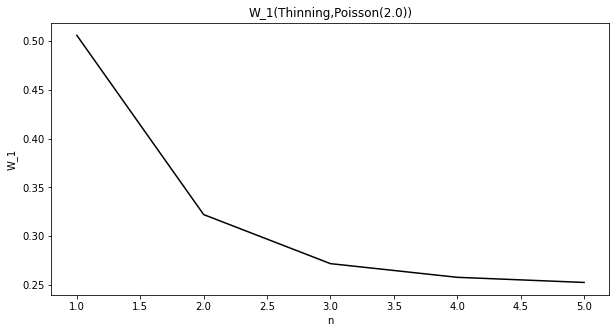

In [16]:
K = 4
l = K

n_max = 5
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

k_star = 1
p = 0.5
lmb = p*K

for n in n_range:
    K_range = range(0,n*K+1)
    
    p1 = get_poisson_pmf_array(K*n, lmb)
    p2 = get_thinning_pmf_array_bin(K, n, l, k_star, p)
    
    #print(f"n={n}, pmf sum={sum(p1)}")
    #print(f"n={n}, pmf sum={sum(p2)}")
    
    plt.figure(figsize=(16,4))
    
    plt.title("Poisson and thinning PMF")
    plt.xlabel("k")
    plt.ylabel("PMF(k)")
    
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    
    plt.legend()
    plt.show()
    
    w = wasserstein_distance(K_range, K_range, p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

thinning_rv = binomial_with_hole_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()

display_wasserstein_distance_info(w_range, n_range, f"Thinning", f"Poisson({lmb})")

## Thinning of uniform distribution with a hole in the support & Poisson distribution

In [ ]:
K = 4
l = K

n_max = 5
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

k_star = 3
p = 0.5
lmb = 1/K

for n in n_range:
    K_range = range(0,n*K+1)
    
    p1 = get_poisson_pmf_array(K*n, lmb)
    p2 = get_thinning_pmf_array_uniform(K, n, l, k_star)
    
    #print(f"n={n}, pmf sum={sum(p1)}")
    #print(f"n={n}, pmf sum={sum(p2)}")
    
    plt.figure(figsize=(16,4))
    
    plt.title("Poisson and thinning PMF")
    plt.xlabel("k")
    plt.ylabel("PMF(k)")
    
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    
    plt.legend()
    plt.show()
    
    w = wasserstein_distance(K_range, K_range, p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

thinning_rv = uniform_with_hole_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()

display_wasserstein_distance_info(w_range, n_range, f"Thinning", f"Poisson({lmb})")

## Thinnings of binomial distributions with a hole in the support

In [ ]:
K = 4
l = K
K_range = range(0,K+1)

n_max = 4
n_step = 1
n_range = range(1,n_max+1,n_step)

w_range = []

entropy = []
rel_entropy = []

for n in n_range:
    K_range = range(0,n*K+1)

    p1 = get_thinning_pmf_array_bin(K, n, l, k_star=1, p=0.5)
    p2 = get_thinning_pmf_array_bin(K, n, l, k_star=2, p=0.7)

    #print(f"n={n}, pmf1 sum={sum(p1)}")
    #print(f"n={n}, pmf2 sum={sum(p2)}")

    plt.figure(figsize=(16,4))

    plt.title(f"Thinning PMF, n={n}")
    plt.xlabel("k")
    plt.ylabel("PMF(k)")
    
    plt.plot(K_range, p1, 'ro', label=f'Thinning1')
    plt.plot(K_range, p2, 'bo', label=f'Thinning2')
    
    plt.legend()
    plt.show()

    w = wasserstein_distance(K_range, K_range, p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

thinning_rv = binomial_with_hole_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print("W_1=",w_range)
print()

display_wasserstein_distance_info(w_range, n_range, f"Thinning1", "Thinning2")

## Thinning of binomial distribution & Thinning of uniform distribution

In [ ]:
K = 4
l = K
K_range = range(0,K+1)

n_max = 4
n_step = 1
n_range = range(1,n_max+1,n_step)

w_range = []

entropy = []
rel_entropy = []

for n in n_range:
    K_range = range(0,n*K+1)

    p1 = get_thinning_pmf_array_bin(K, n, l, k_star=-1, p=0.5)
    p2 = get_thinning_pmf_array_uniform(K, n, l, k_star=-1)

    #print(f"n={n}, pmf1 sum={sum(p1)}")
    #print(f"n={n}, pmf2 sum={sum(p2)}")

    plt.figure(figsize=(16,4))

    plt.title(f"Thinning PMF, n={n}")
    plt.xlabel("k")
    plt.ylabel("PMF(k)")
    
    plt.plot(K_range, p1, 'ro', label=f'Thinning1')
    plt.plot(K_range, p2, 'bo', label=f'Thinning2')
    
    plt.legend()
    plt.show()

    w = wasserstein_distance(K_range, K_range, p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

thinning_rv = binomial_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print("W_1=",w_range)
print()

display_wasserstein_distance_info(w_range, n_range, f"Thinning1", "Thinning2")

## Thinning of geometric distribution & Poisson distribution

In [ ]:
K = 4
l = K

n_max = 5
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

k_star = 1
p = 0.5
lmb = (1-p)/p

for n in n_range:
    K_range = range(0,n*K+1)
    
    p1 = get_poisson_pmf_array(K*n, lmb)
    p2 = get_thinning_pmf_array_geom(K, n, l, k_star=-1, p=p)
    
    #print(f"n={n}, pmf sum={sum(p1)}")
    #print(f"n={n}, pmf sum={sum(p2)}")
    
    plt.figure(figsize=(16,4))
    
    plt.title("Poisson and thinning PMF")
    plt.xlabel("k")
    plt.ylabel("PMF(k)")
    
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    
    plt.legend()
    plt.show()
    
    w = wasserstein_distance(K_range, K_range, p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

thinning_rv = geometric_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()

display_wasserstein_distance_info(w_range, n_range, f"Thinning", f"Poisson({lmb})")

## Thinning of  binomial distribution & Poisson distribution

In [ ]:
K = 4
l = K

n_max = 5
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

p = 0.5
lmb = p*K

for n in n_range:
    K_range = range(0,n*K+1)
    
    p1 = get_poisson_pmf_array(K*n, lmb)
    p2 = get_thinning_pmf_array_bin(K, n, l, k_star=-1, p=p)
    
    #print(f"n={n}, pmf sum={sum(p1)}")
    #print(f"n={n}, pmf sum={sum(p2)}")
    
    plt.figure(figsize=(16,4))
    
    plt.title("Poisson and thinning PMF")
    plt.xlabel("k")
    plt.ylabel("PMF(k)")
    
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    
    plt.legend()
    plt.show()
    
    w = wasserstein_distance(K_range, K_range, p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

thinning_rv = binomial_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()

display_wasserstein_distance_info(w_range, n_range, f"Thinning", f"Poisson({lmb})")

## Thinning of uniform distribution & Poisson distribution

In [ ]:
K = 4
l = K

n_max = 5
n_step = 1
n_range = range(1,n_max+1,n_step)
w_range = []

entropy = []
rel_entropy = []

k_star = 3
p = 0.5
lmb = 1/K

for n in n_range:
    K_range = range(0,n*K+1)
    
    p1 = get_poisson_pmf_array(K*n, lmb)
    p2 = get_thinning_pmf_array_uniform(K, n, l, k_star=-1)
    
    #print(f"n={n}, pmf sum={sum(p1)}")
    #print(f"n={n}, pmf sum={sum(p2)}")
    
    plt.figure(figsize=(16,4))
    
    plt.title("Poisson and thinning PMF")
    plt.xlabel("k")
    plt.ylabel("PMF(k)")
    
    plt.plot(K_range, p1, 'ro', label=f'Poisson({lmb})')
    plt.plot(K_range, p2, 'bo', label=f'Thinning, n={n}')
    
    plt.legend()
    plt.show()
    
    w = wasserstein_distance(K_range, K_range, p1, p2)
    w_range.append(w)
    
    rel_entropy.append(get_relative_entropy(p2, p1))
    entropy.append(get_relative_entropy(p2))

thinning_rv = uniform_const

print(f"H({thinning_rv}|Poisson({lmb})) is monotonically decreasing: {is_monot_decreasing(rel_entropy)} (should always be true)")
print(rel_entropy)
print()
print(f"H({thinning_rv}) is monotonically increasing: {is_monot_increasing(entropy)} (should be true in ULC case)")
print(f"H({thinning_rv}) is monotonically decreasing: {is_monot_decreasing(entropy)} (should be true in ULConvex case)")
print(entropy)
print()
print(f"H({thinning_rv})_{n_max}={entropy[-1]}, H(Poisson({lmb}))={scipy.stats.entropy(p1)}")
print(f"H({thinning_rv}|Poisson({lmb}))={rel_entropy[-1]}")
    
print()
print(w_range)
print()

display_wasserstein_distance_info(w_range, n_range, f"Thinning", f"Poisson({lmb})")